In [2]:


import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

#from aesara import tensor as at
from matplotlib.patches import Ellipse, transforms
from scipy import stats

my_target_accept = 0.8 #is faster
pro_target_accept = 0.99 #takes ages


In [3]:


%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"



In [4]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

Dmat = pd.read_csv("islandsDistMatrix.csv", sep=",", index_col=0)
Dmat.round(1)



,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


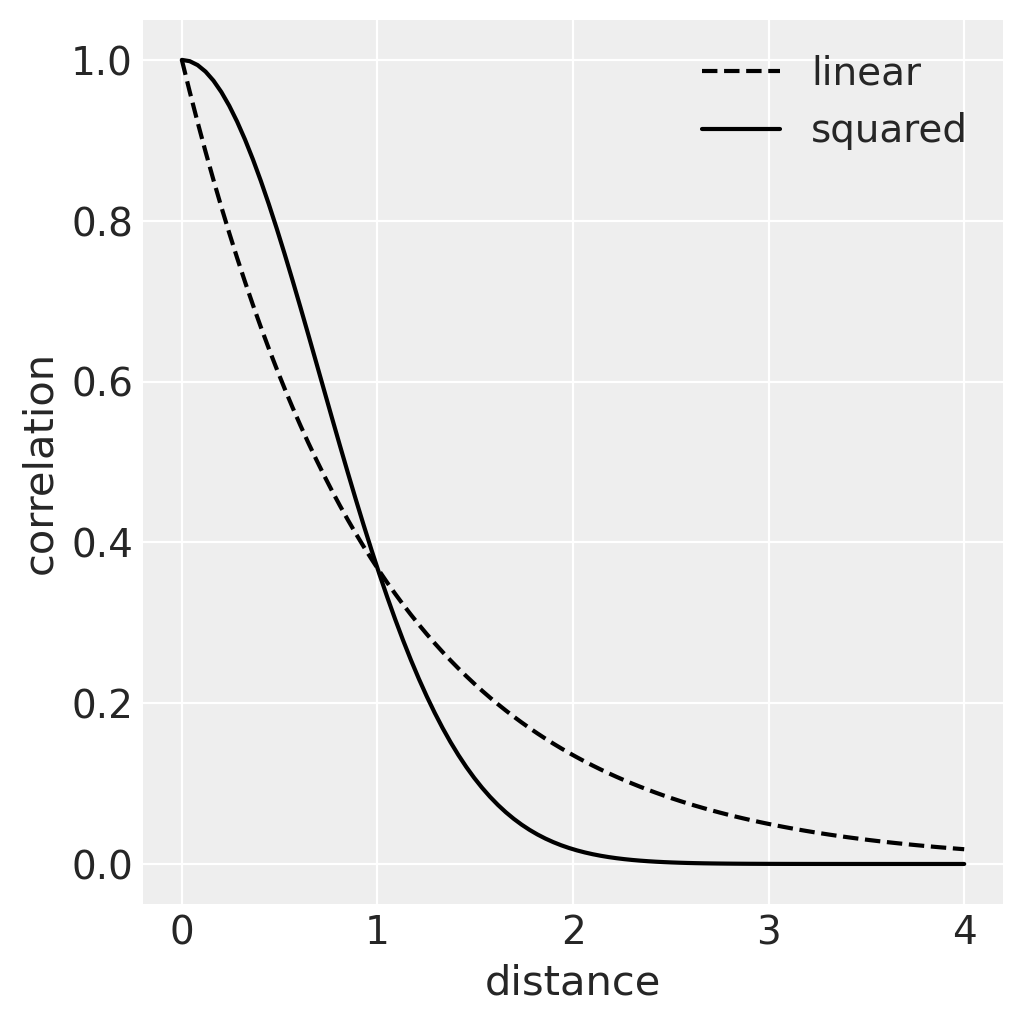

In [5]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

xrange = np.linspace(0, 4, 100)
# linear
ax.plot(xrange, np.exp(-1 * xrange), "k--", label="linear")
# squared
ax.plot(xrange, np.exp(-1 * xrange**2), "k", label="squared")

ax.set_xlabel("distance")
ax.set_ylabel("correlation")
plt.legend();

In [6]:
# load the ordinary data, now with coordinates
dk = pd.read_csv("Kline2.csv", sep=",")

Nsociety = dk.shape[0]
society = np.arange(Nsociety)
total_tools = dk.total_tools.values

Dmat = Dmat.values
Dmatsq = np.power(Dmat, 2)

P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0, see chp 11

dk

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


In [ ]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * pm.math.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=my_target_accept, random_seed=RANDOM_SEED)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, etasq, ls_inv, k_rotated_]


In [ ]:
az.plot_trace(trace_14_8, var_names=["~k_rotated_"], compact=True);